## Quasistatic vertex models

Quasitatic vertex models are based on the minimisation of a potential energy depending on the tissue geometry.

It is the original formalism defined by Honda et al., and in its most widely used form by Farhadifar et al..

`tyssue` provides a way to easily define such a potential and find the corresponding energy minimum through gradient descent.


In [1]:
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline

from scipy import optimize

from tyssue import Sheet, config
from tyssue import SheetGeometry as geom
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import SheetModel as model
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5


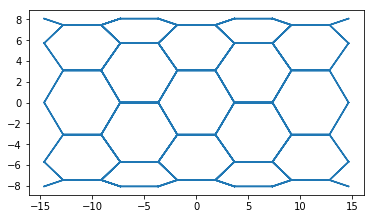

In [2]:
h5store = '../examples/small_hexagonal.hf5'
#h5store = '../examples/before_apoptosis.hf5'

datasets = hdf5.load_datasets(h5store,
                              data_names=['face', 'vert', 'edge'])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)


geom.update_all(sheet)


fig, ax = sheet_view(sheet, ['z', 'x'], mode='quick')

### Effector classes

An effector designates a dynamical term in the epithelium governing equation. For quasistatic models, we need to provide  a method to compute the energy associated with this effector, and the corresponding gradient. 

For example, we can consider a line tension effector. The energy is $E_t = \sum_{ij} \Lambda\ell_{ij}$ where the sum is over all the edges. For each half-edge, the gradient of $E_t$ is defined by two terms, one for the gradient term associated with the half-edge ${ij}$ source, the over for it's target. For the $x$ coordinate:
$$
\frac{\partial E_t}{\partial x_i}
= \Lambda\left(\sum_k \frac{\partial \ell_{ik}}{\partial x_i} + \sum_m \frac{\partial \ell_{mi}}{\partial x_i}\right)
= \Lambda\left(\sum_k \frac{x_i}{\ell_{ik}}  - \sum_m \frac{x_i}{\ell_{mi}}\right)
$$

Where $\sum_k$ is are over all the edges which vertex $i$ is a source, and $\sum_m$ over all the edges of which vertex i is a target. 


Here is the definition of the line tension effector:
```python
class LineTension(AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension"
    label = "Line tension"
    element = "edge"
    specs = {"edge": {"is_active", "line_tension"}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension" "* is_active" "* length / 2"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension * is_active/2"), len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt
```

For quasistatic methods, this effectors is agregated with others to define a `model` object. This object will have two methods `compute_energy` and `compute_gradient` that take an `Epithelium` object as single argument.


In [3]:
model_specs = {
    "edge": {
        "line_tension": 1.,
    },
    "face": {
        "contractility": 1.,
        "vol_elasticity": 1.,
        "prefered_vol": sheet.face_df["vol"].mean(),
    },
}

sheet.update_specs(model_specs, reset=True)

Reseting column line_tension of the edge dataset with new specs
Reseting column contractility of the face dataset with new specs
Reseting column vol_elasticity of the face dataset with new specs
Reseting column prefered_vol of the face dataset with new specs


In [4]:
Et, Ec, Ev = model.compute_energy(sheet, full_output=True)
energy = model.compute_energy(sheet, full_output=False)
print('Total energy: {}'.format(energy))

Total energy: 10021.355059473477


In [5]:
grad_E = model.compute_gradient(sheet)

grad_E.head()

,gx,gy,gz
srce,,,
0,7.553548,7.105427e-15,-22.498252
1,6.978568,2.890617e+00,-22.282000
2,5.341165,5.341165e+00,-22.498252
3,6.978568,-2.890617e+00,-22.282000
4,13.957136,-5.781235e+00,-0.216253


In [6]:
model.labels

['Line tension', 'Contractility', 'Volume elasticity']

In [7]:
gradients = model.compute_gradient(sheet, components=True)
gradients = {label: (srce, trgt) for label, (srce, trgt)
             in zip(model.labels, gradients)}
gradients['Line tension'][0].head()

,gx,gy,gz
edge,,,
0,0.08434,-0.424007,-0.251207
1,-0.08434,-0.424007,0.251207
2,-0.00000,-0.000000,-0.500000
3,-0.00000,-0.000000,0.500000
4,0.08434,0.424007,0.251207


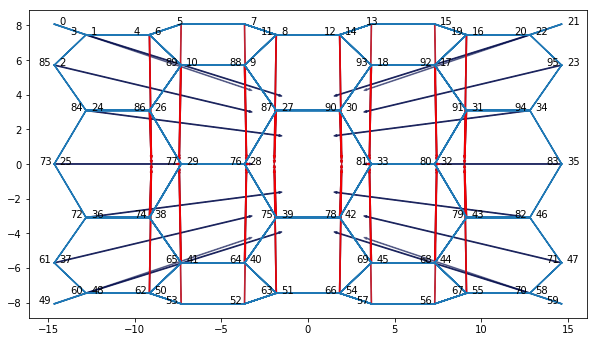

In [9]:
solver = QSSolver()

scale = 0.5
fig, ax = plot_forces(sheet, geom, model, ['z', 'x'], scale)
fig.set_size_inches(10, 12)
for n, (vx, vy, vz) in sheet.vert_df[sheet.coords].iterrows():
    shift = 0.6 * np.sign(vy)
    ax.text(vz+shift-0.3, vx, str(n))

app_grad_specs = config.draw.sheet_spec()['grad']
app_grad_specs.update({'color':'r'})
    
def draw_approx_force(ax=None):
    fig, ax = plot_forces(sheet, geom, model,
                          ['z', 'x'], scaling=scale, ax=ax,
                          approx_grad=solver.approx_grad, **{'grad':app_grad_specs})
    fig.set_size_inches(10, 12)
    return fig, ax

## Uncomment bellow to recompute
fig, ax = draw_approx_force(ax=ax)
#fig

In [20]:
sheet.edge_df.line_tension = bck_lt.copy()
sheet.face_df.contractility = bck_ct.copy()
sheet.face_df.vol_elasticity = bck_ve.copy()

http://scipy.github.io/devdocs/generated/scipy.optimize.check_grad.html#scipy.optimize.check_grad

In [ ]:

grad_err = solver.check_grad(sheet, geom, model)
grad_err /= sheet.vert_df.size


print("Error on the gradient (non-dim, per vertex): {:.3e}".format(grad_err))


In [ ]:
options ={'disp':False,
          'ftol':1e-5,
          'gtol':1e-5}


res = solver.find_energy_min(sheet, geom, model, options=options)
print(res['success'])

In [ ]:
res['message']

In [ ]:
res['fun']/sheet.face_df.is_alive.sum()

In [ ]:
fig, ax = draw.plot_forces(sheet, geom, model, ['z', 'y'], 10)
fig.set_size_inches(10, 12)
